In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import kagglehub


c:\Users\Begad\anaconda3\envs\tf27\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Load Dataset with KaggleHub

path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print("Path to dataset files:", path)

# Adjust path based on dataset folder structure
dataset_path = os.path.join(path, "Garbage classification", "Garbage classification")

classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)
print(f"We have {num_classes} classes")

total_images = 0
for c in classes:
    images = os.listdir(os.path.join(dataset_path, c))
    total_images += len(images)
    print(f"{c}: {len(images)} images")
print(f"Total Images are: {total_images}")



Path to dataset files: C:\Users\Begad\.cache\kagglehub\datasets\asdasdasasdas\garbage-classification\versions\2
We have 6 classes
cardboard: 403 images
glass: 501 images
metal: 410 images
paper: 594 images
plastic: 482 images
trash: 137 images
Total Images are: 2527


In [ ]:
# Load and Preprocess Images
def load_images(dataset_path, classes, img_size=(64, 64)):
    images = []
    labels = []
    for idx, cls in enumerate(classes):
        cls_path = os.path.join(dataset_path, cls)
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                img = cv2.imread(os.path.join(cls_path, fname))
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(idx)
    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)
    X = (X / 127.5) - 1.0  # Normalize to [-1, 1]
    return X, y

X_train, y_train = load_images(dataset_path, classes)



In [ ]:
img_rows, img_cols, channels = 64, 64, 3
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
optimizer = Adam(0.0001, 0.5)



In [ ]:
#Generator 

def build_generator():
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, 50)(label)
    label_embedding = Flatten()(label_embedding)

    model_input = Concatenate()([noise, label_embedding])

    # Dense to 8x8 feature map
    x = Dense(256 * 8 * 8, activation="relu")(model_input)
    x = Reshape((8, 8, 256))(x)
    x = BatchNormalization(momentum=0.8)(x)

    # Upsample to 16x16
    x = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    # Upsample to 32x32
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    # Upsample to 64x64
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    img = Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh')(x)

    return Model([noise, label], img)



In [ ]:
# Discriminator 

def build_discriminator():
    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype="int32")

    # Feature extractor
    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(img)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)

    features = Dense(128)(x)  
    label_embedding = Embedding(num_classes, 128)(label)
    label_embedding = Flatten()(label_embedding)

    projection = tf.reduce_sum(features * label_embedding, axis=1, keepdims=True)

    validity = Dense(1, activation="sigmoid")(features)  # <-- sigmoid output

    # Combine validity and projection, then sigmoid again
    output = tf.keras.layers.Activation("sigmoid")(validity + projection)

    return Model([img, label], output)


In [ ]:

# Build & Compile Models

# Build discriminator
discriminator = build_discriminator()
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.0002, 0.5),
    metrics=["accuracy"]
)

# Build generator
generator = build_generator()

# Inputs for combined model
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))

# Generate image and get discriminator's output
img = generator([noise, label])
discriminator.trainable = False
valid = discriminator([img, label])

# Build combined model
combined = Model([noise, label], valid)

# Compile combined model
optimizer = Adam(0.0001, 0.5)
combined.compile(loss="binary_crossentropy", optimizer=optimizer)

0 [D loss: 0.7256, acc.: 0.00%] [G loss: 0.4427]


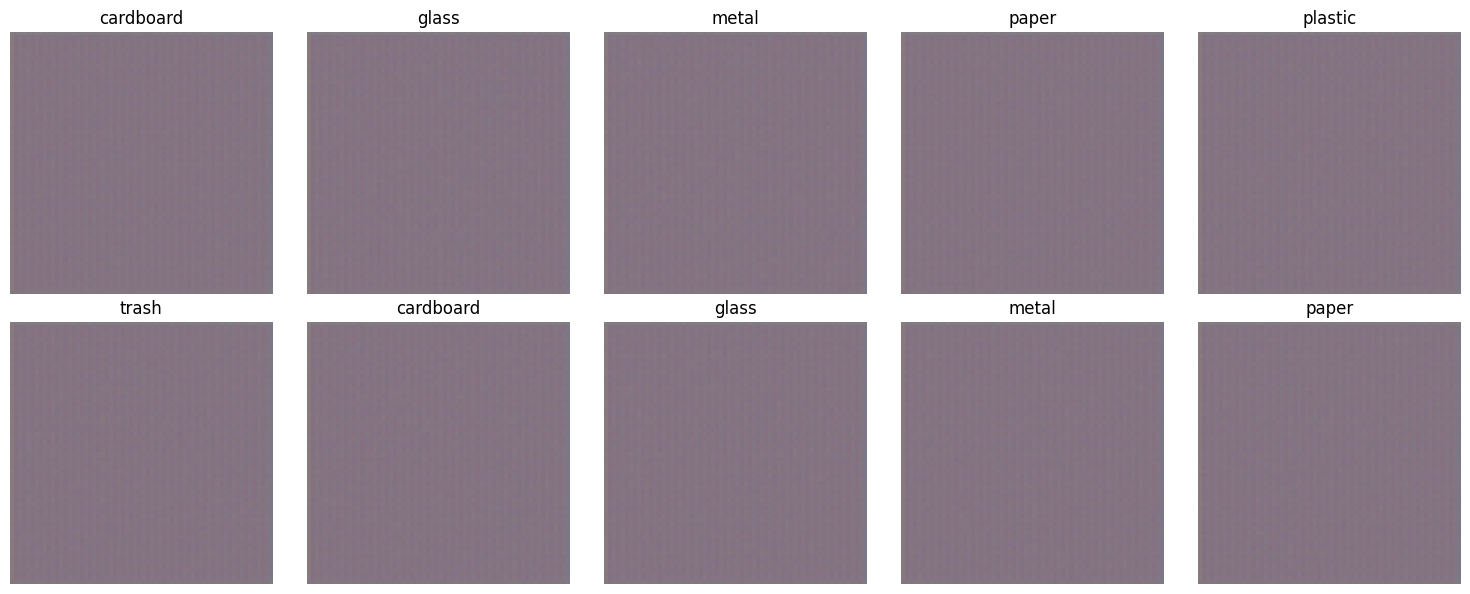

100 [D loss: 0.3938, acc.: 0.00%] [G loss: 2.0888]
200 [D loss: 0.4250, acc.: 0.00%] [G loss: 1.4378]
300 [D loss: 0.5372, acc.: 0.00%] [G loss: 1.4956]
400 [D loss: 0.5709, acc.: 0.00%] [G loss: 1.6751]
500 [D loss: 0.3722, acc.: 0.00%] [G loss: 1.9551]
600 [D loss: 0.3865, acc.: 0.00%] [G loss: 1.7993]
700 [D loss: 0.4421, acc.: 0.00%] [G loss: 1.8885]
800 [D loss: 0.5831, acc.: 0.00%] [G loss: 1.5393]
900 [D loss: 0.4799, acc.: 0.00%] [G loss: 1.6530]
1000 [D loss: 0.5260, acc.: 0.00%] [G loss: 2.0947]


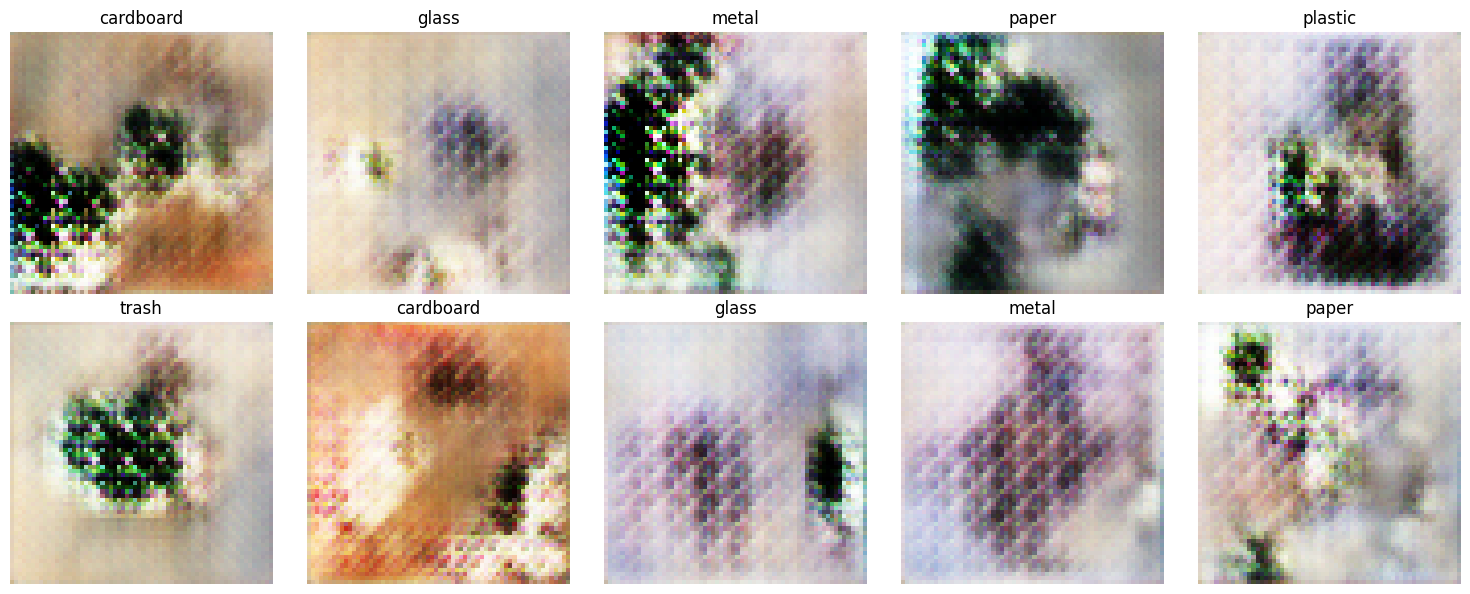

1100 [D loss: 0.4490, acc.: 0.00%] [G loss: 1.9940]
1200 [D loss: 0.5692, acc.: 0.00%] [G loss: 1.6182]
1300 [D loss: 0.4634, acc.: 0.00%] [G loss: 1.6444]
1400 [D loss: 0.4609, acc.: 0.00%] [G loss: 1.8059]
1500 [D loss: 0.5486, acc.: 0.00%] [G loss: 1.8591]
1600 [D loss: 0.4424, acc.: 0.00%] [G loss: 1.6930]
1700 [D loss: 0.4610, acc.: 0.00%] [G loss: 1.6141]
1800 [D loss: 0.4581, acc.: 0.00%] [G loss: 1.5952]
1900 [D loss: 0.4641, acc.: 0.00%] [G loss: 1.7169]
2000 [D loss: 0.3984, acc.: 0.00%] [G loss: 1.8520]


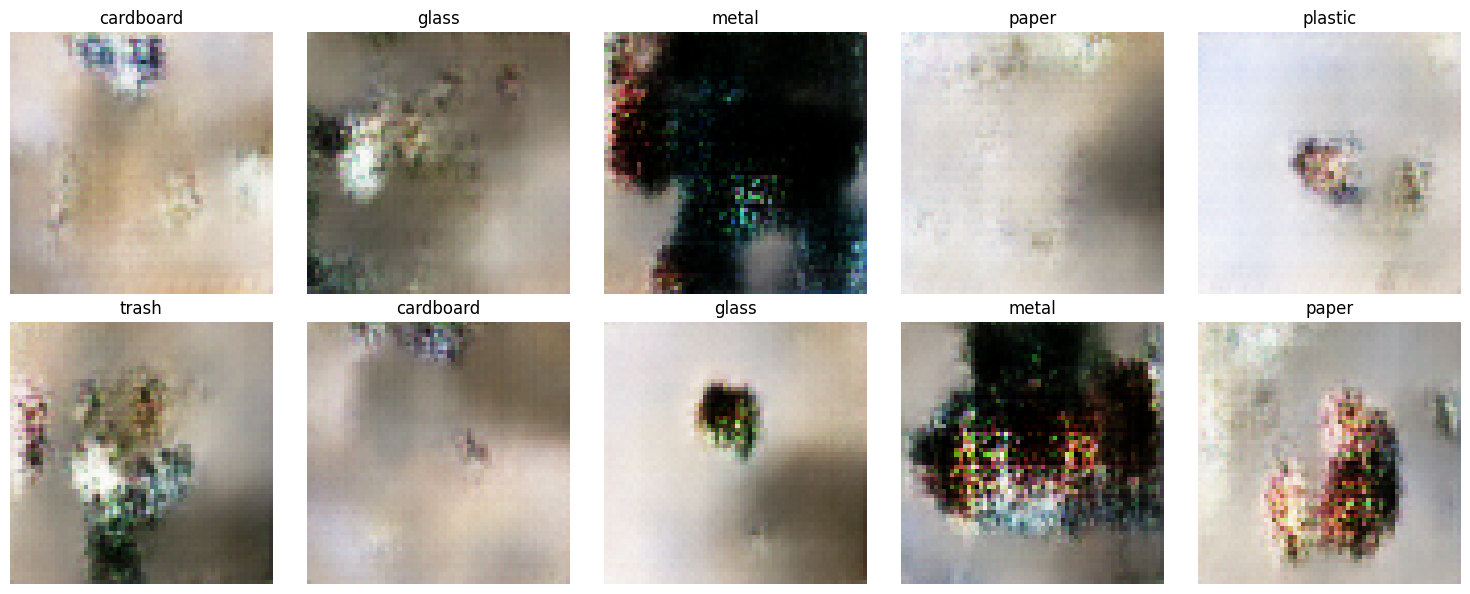

2100 [D loss: 0.4245, acc.: 0.00%] [G loss: 1.8649]
2200 [D loss: 0.4220, acc.: 0.00%] [G loss: 1.9653]
2300 [D loss: 0.4228, acc.: 0.00%] [G loss: 1.7011]
2400 [D loss: 0.4491, acc.: 0.00%] [G loss: 1.7542]
2500 [D loss: 0.4664, acc.: 0.00%] [G loss: 1.6823]
2600 [D loss: 0.3992, acc.: 0.00%] [G loss: 1.8487]
2700 [D loss: 0.4450, acc.: 0.00%] [G loss: 1.7419]
2800 [D loss: 0.4804, acc.: 0.00%] [G loss: 1.5635]
2900 [D loss: 0.5261, acc.: 0.00%] [G loss: 1.9434]
3000 [D loss: 0.4326, acc.: 0.00%] [G loss: 1.8977]


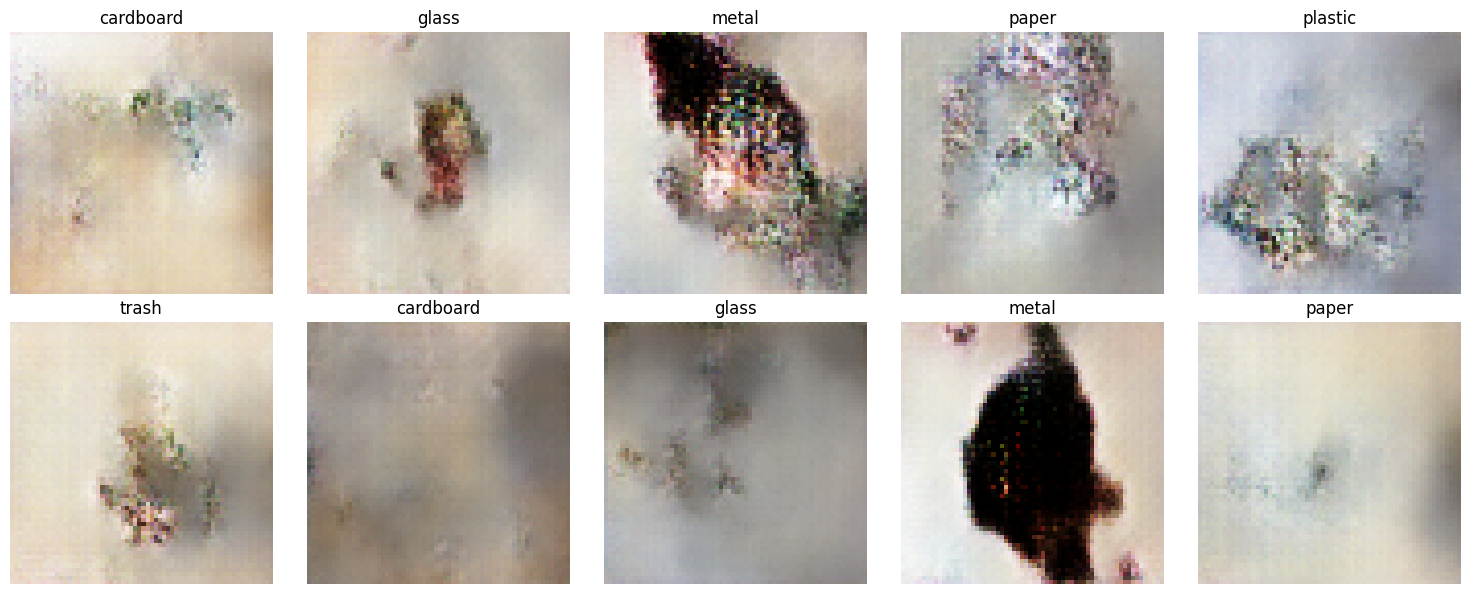

3100 [D loss: 0.4276, acc.: 0.00%] [G loss: 1.9242]
3200 [D loss: 0.3951, acc.: 0.00%] [G loss: 1.8150]
3300 [D loss: 0.4450, acc.: 0.00%] [G loss: 1.7974]
3400 [D loss: 0.4730, acc.: 0.00%] [G loss: 1.8477]
3500 [D loss: 0.4504, acc.: 0.00%] [G loss: 1.7294]
3600 [D loss: 0.4434, acc.: 0.00%] [G loss: 1.8159]
3700 [D loss: 0.4529, acc.: 0.00%] [G loss: 2.3964]
3800 [D loss: 0.4044, acc.: 0.00%] [G loss: 2.0282]
3900 [D loss: 0.4782, acc.: 0.00%] [G loss: 1.6756]
4000 [D loss: 0.4422, acc.: 0.00%] [G loss: 1.7527]


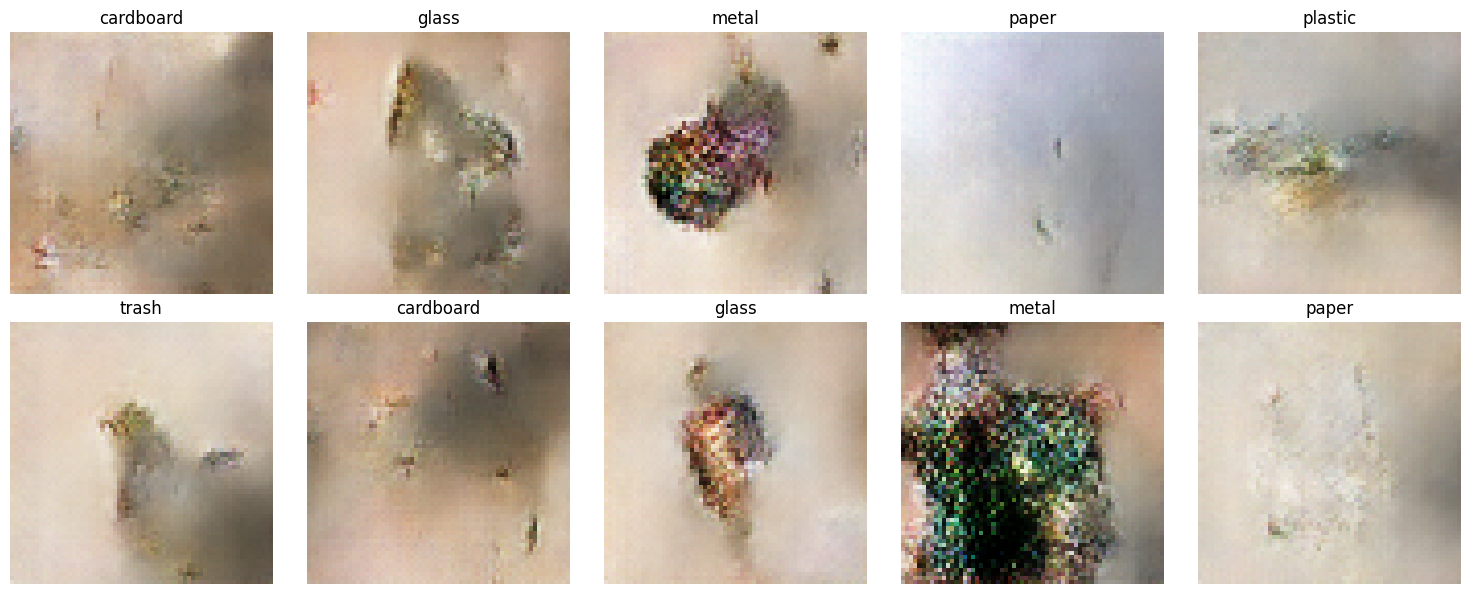

4100 [D loss: 0.4505, acc.: 0.00%] [G loss: 1.6962]
4200 [D loss: 0.4623, acc.: 0.00%] [G loss: 1.7636]
4300 [D loss: 0.5092, acc.: 0.00%] [G loss: 2.0150]
4400 [D loss: 0.4545, acc.: 0.00%] [G loss: 1.7306]
4500 [D loss: 0.4084, acc.: 0.00%] [G loss: 1.6978]
4600 [D loss: 0.4660, acc.: 0.00%] [G loss: 1.8391]
4700 [D loss: 0.4469, acc.: 0.00%] [G loss: 1.8183]
4800 [D loss: 0.4305, acc.: 0.00%] [G loss: 2.2004]
4900 [D loss: 0.4341, acc.: 0.00%] [G loss: 1.9849]
5000 [D loss: 0.5107, acc.: 0.00%] [G loss: 2.0799]


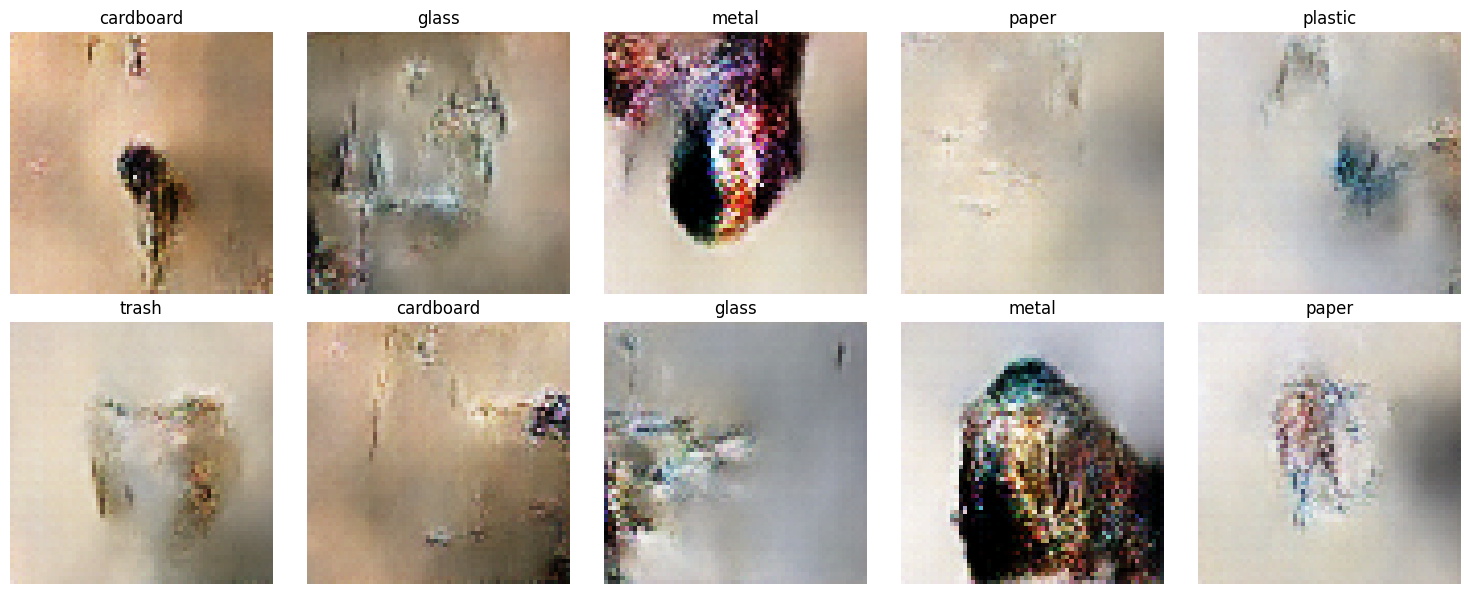

5100 [D loss: 0.4282, acc.: 0.00%] [G loss: 1.9305]
5200 [D loss: 0.4216, acc.: 0.00%] [G loss: 1.7420]
5300 [D loss: 0.4284, acc.: 0.00%] [G loss: 1.9453]
5400 [D loss: 0.3858, acc.: 0.00%] [G loss: 2.1466]
5500 [D loss: 0.3922, acc.: 0.00%] [G loss: 1.9900]
5600 [D loss: 0.4713, acc.: 0.00%] [G loss: 1.6100]
5700 [D loss: 0.4074, acc.: 0.00%] [G loss: 1.9090]
5800 [D loss: 0.4581, acc.: 0.00%] [G loss: 1.7505]
5900 [D loss: 0.4154, acc.: 0.00%] [G loss: 1.7589]
6000 [D loss: 0.4185, acc.: 0.00%] [G loss: 2.1043]


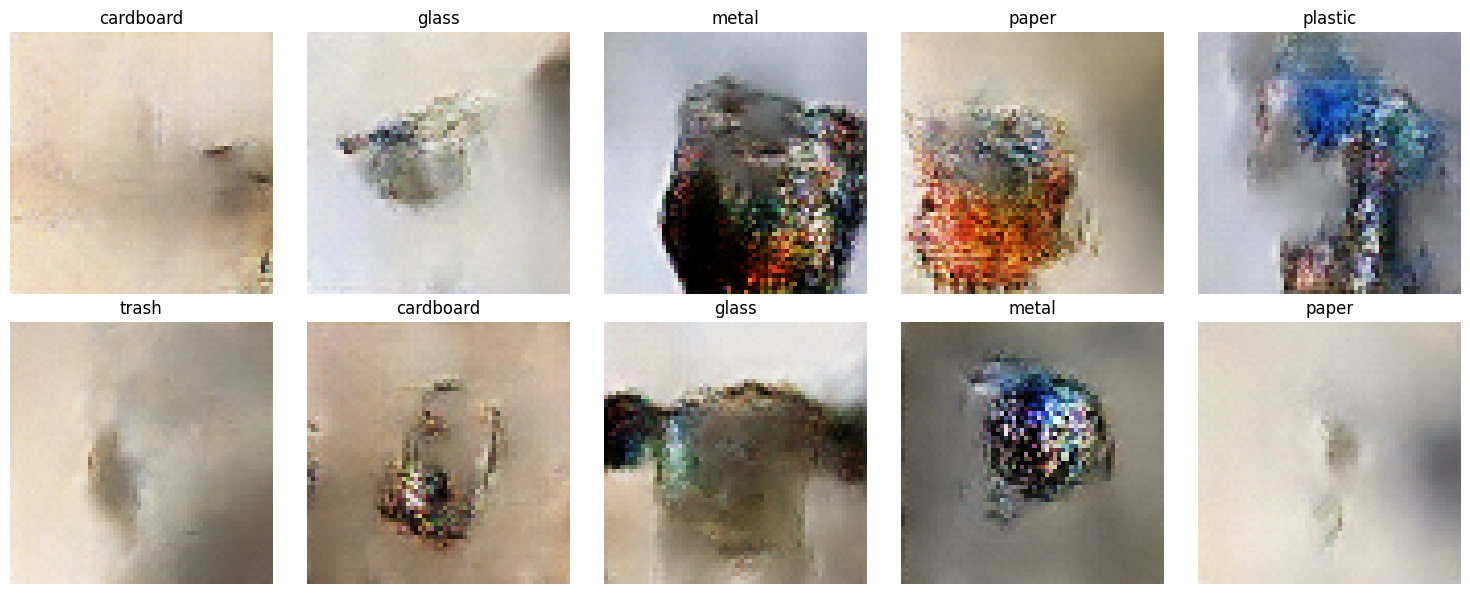

6100 [D loss: 0.4403, acc.: 0.00%] [G loss: 1.8036]
6200 [D loss: 0.4098, acc.: 0.00%] [G loss: 1.8379]
6300 [D loss: 0.3822, acc.: 0.00%] [G loss: 1.7209]
6400 [D loss: 0.3934, acc.: 0.00%] [G loss: 1.9871]
6500 [D loss: 0.4545, acc.: 0.00%] [G loss: 1.8661]
6600 [D loss: 0.4054, acc.: 0.00%] [G loss: 1.9594]
6700 [D loss: 0.4303, acc.: 0.00%] [G loss: 1.9447]
6800 [D loss: 0.4124, acc.: 0.00%] [G loss: 1.8873]
6900 [D loss: 0.4024, acc.: 0.00%] [G loss: 2.1571]
7000 [D loss: 0.4755, acc.: 0.00%] [G loss: 2.1927]


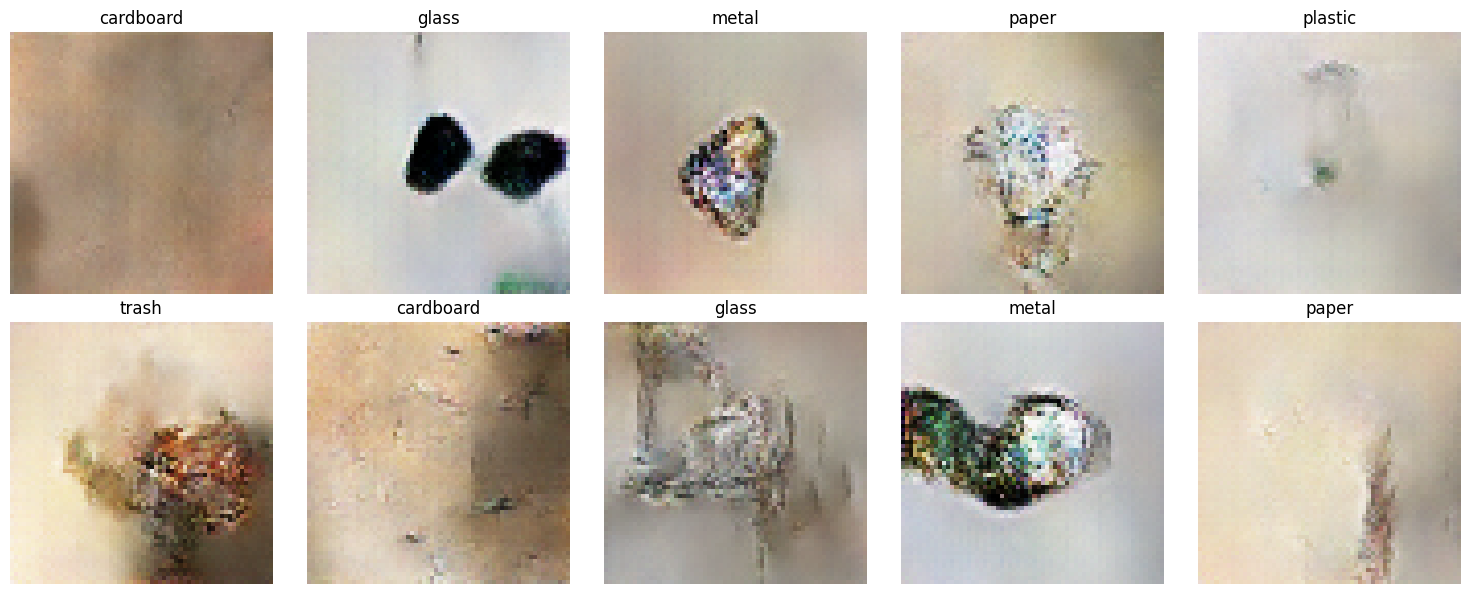

7100 [D loss: 0.4044, acc.: 0.00%] [G loss: 2.0548]
7200 [D loss: 0.4040, acc.: 0.00%] [G loss: 2.0762]
7300 [D loss: 5.4888, acc.: 0.00%] [G loss: 4.6453]
7400 [D loss: 0.4148, acc.: 0.00%] [G loss: 1.7786]
7500 [D loss: 0.3833, acc.: 0.00%] [G loss: 1.7999]
7600 [D loss: 0.4053, acc.: 0.00%] [G loss: 1.8269]
7700 [D loss: 0.3763, acc.: 0.00%] [G loss: 1.8538]
7800 [D loss: 0.3742, acc.: 0.00%] [G loss: 1.8599]
7900 [D loss: 0.3807, acc.: 0.00%] [G loss: 1.8383]
8000 [D loss: 0.4247, acc.: 0.00%] [G loss: 1.7060]


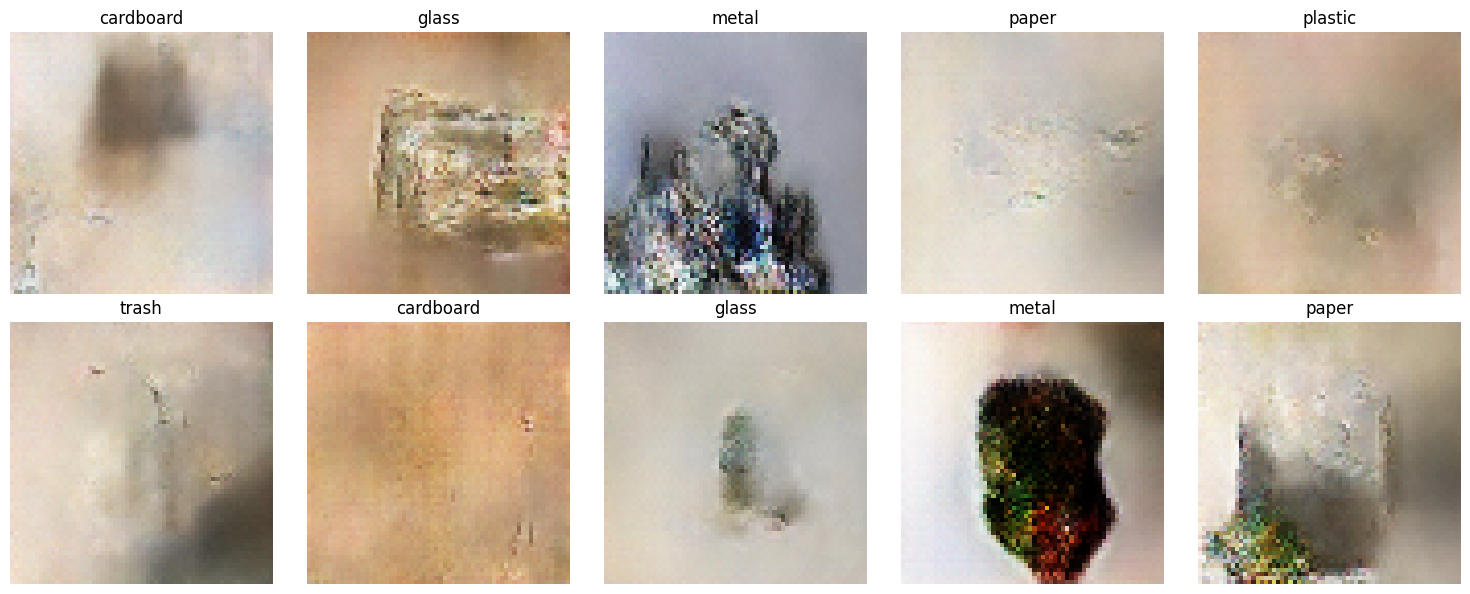

8100 [D loss: 0.3853, acc.: 0.00%] [G loss: 1.7340]
8200 [D loss: 3.9852, acc.: 0.00%] [G loss: 2.6027]
8300 [D loss: 0.4109, acc.: 0.00%] [G loss: 1.9023]
8400 [D loss: 0.3799, acc.: 0.00%] [G loss: 1.8594]
8500 [D loss: 0.4276, acc.: 0.00%] [G loss: 1.9850]
8600 [D loss: 0.4030, acc.: 0.00%] [G loss: 1.9653]
8700 [D loss: 0.3757, acc.: 0.00%] [G loss: 2.2401]
8800 [D loss: 0.3952, acc.: 0.00%] [G loss: 2.1063]
8900 [D loss: 0.4284, acc.: 0.00%] [G loss: 1.9407]
9000 [D loss: 0.4252, acc.: 0.00%] [G loss: 2.0371]


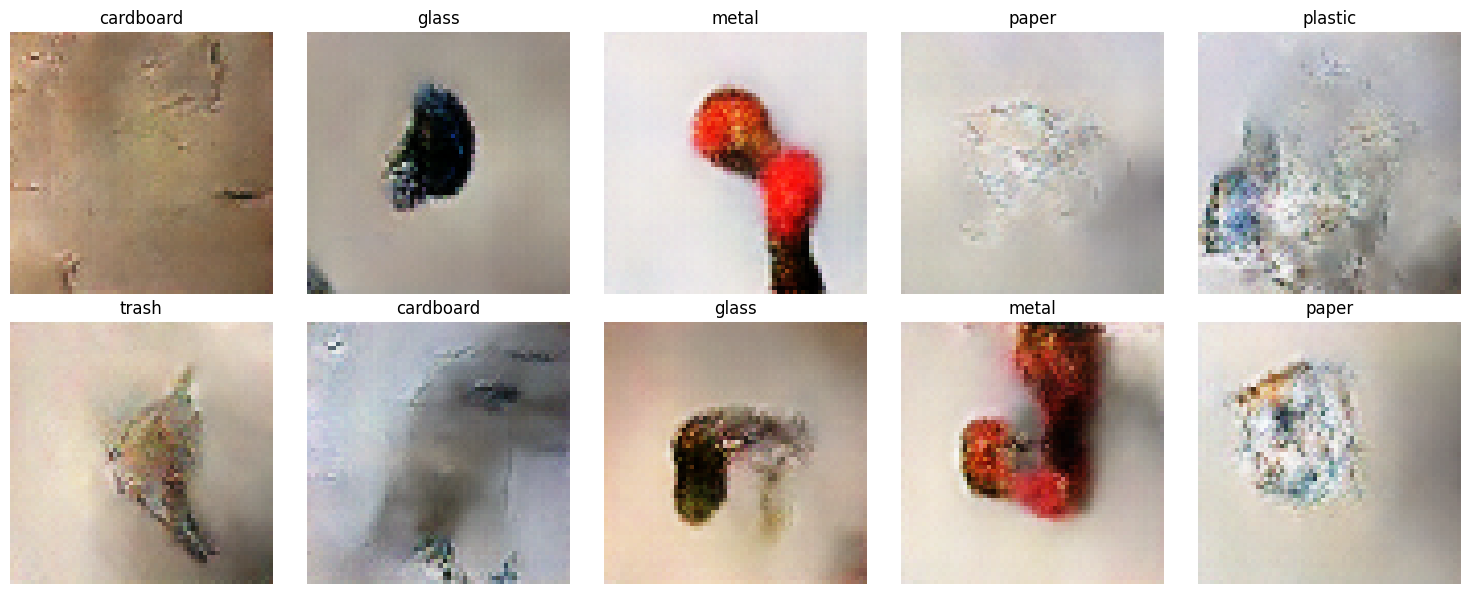

9100 [D loss: 0.3945, acc.: 0.00%] [G loss: 1.9658]
9200 [D loss: 0.4420, acc.: 0.00%] [G loss: 1.9219]
9300 [D loss: 0.4000, acc.: 0.00%] [G loss: 1.9868]
9400 [D loss: 0.3968, acc.: 0.00%] [G loss: 2.3111]
9500 [D loss: 0.4212, acc.: 0.00%] [G loss: 1.8302]
9600 [D loss: 0.3882, acc.: 0.00%] [G loss: 2.0716]
9700 [D loss: 0.3924, acc.: 0.00%] [G loss: 2.1207]
9800 [D loss: 0.4069, acc.: 0.00%] [G loss: 1.8614]
9900 [D loss: 0.4044, acc.: 0.00%] [G loss: 1.9788]
10000 [D loss: 0.4099, acc.: 0.00%] [G loss: 2.0111]


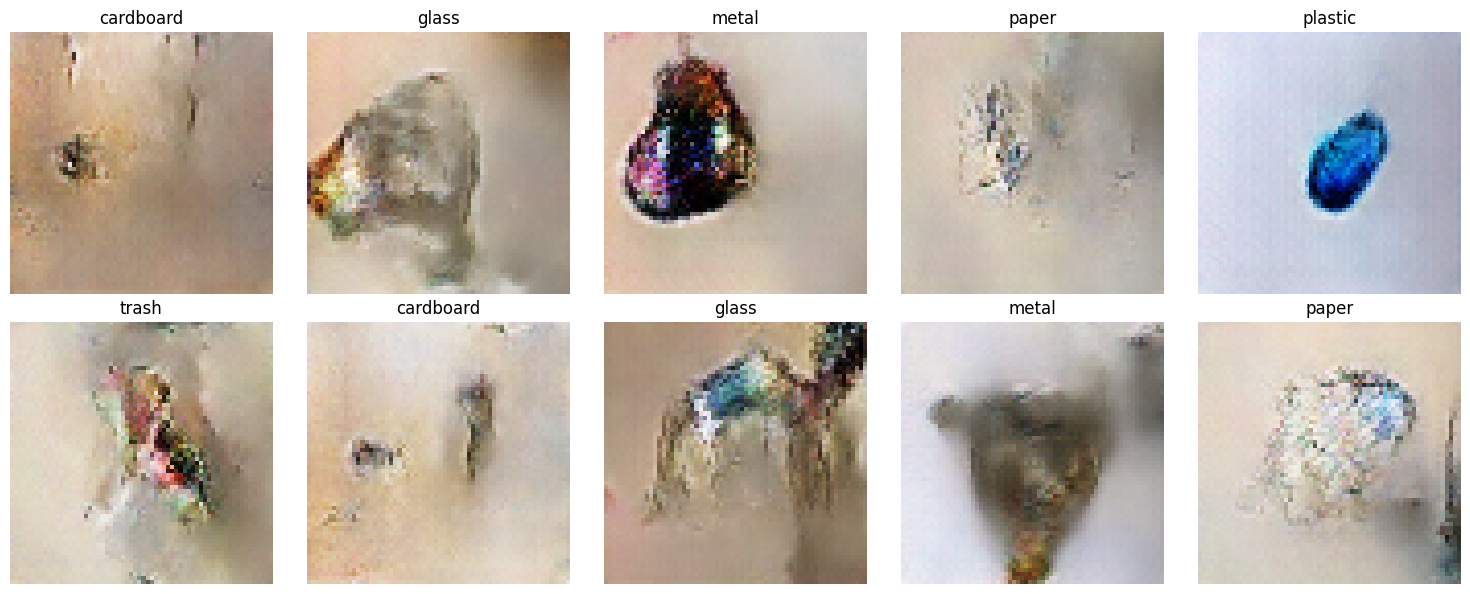

10100 [D loss: 0.3969, acc.: 0.00%] [G loss: 2.1512]
10200 [D loss: 0.3831, acc.: 0.00%] [G loss: 1.9264]
10300 [D loss: 0.3952, acc.: 0.00%] [G loss: 2.1438]
10400 [D loss: 0.4215, acc.: 0.00%] [G loss: 1.9372]
10500 [D loss: 0.3820, acc.: 0.00%] [G loss: 1.9994]
10600 [D loss: 0.4007, acc.: 0.00%] [G loss: 1.9443]
10700 [D loss: 0.3965, acc.: 0.00%] [G loss: 2.2764]
10800 [D loss: 0.4117, acc.: 0.00%] [G loss: 1.8661]
10900 [D loss: 0.3939, acc.: 0.00%] [G loss: 1.9499]
11000 [D loss: 0.3973, acc.: 0.00%] [G loss: 2.1857]


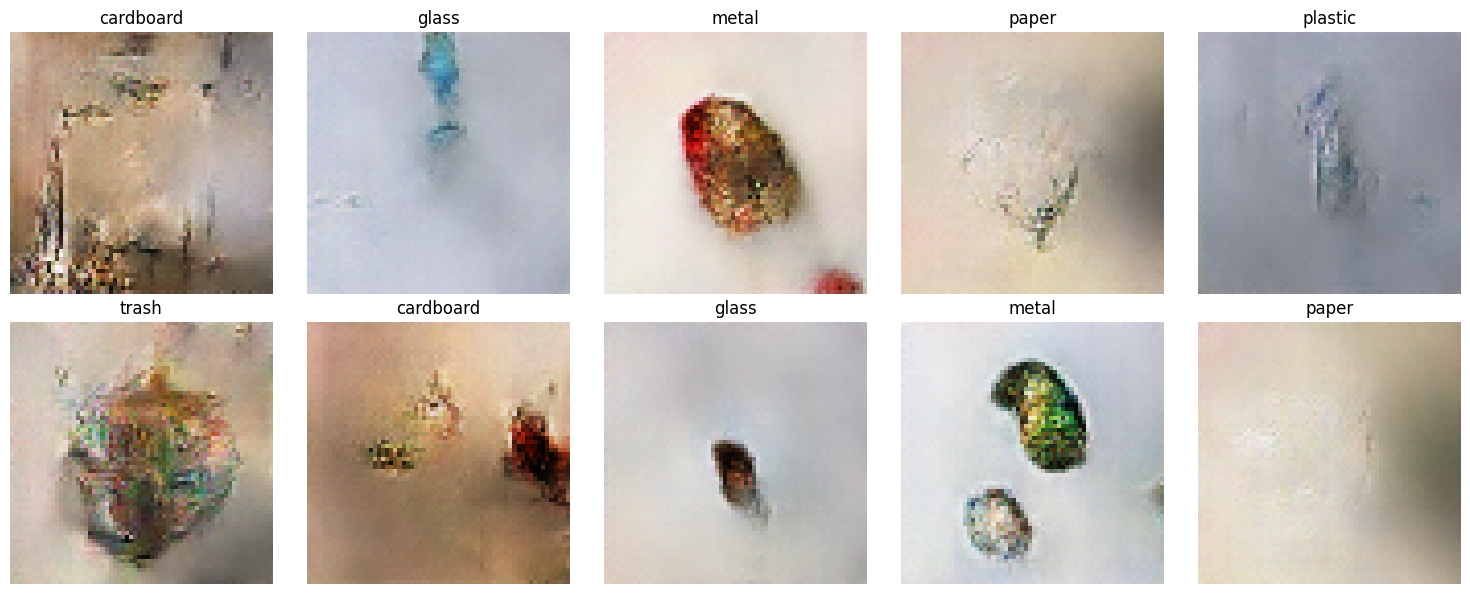

11100 [D loss: 0.3819, acc.: 0.00%] [G loss: 2.1848]
11200 [D loss: 0.3781, acc.: 0.00%] [G loss: 2.1768]
11300 [D loss: 0.3908, acc.: 0.00%] [G loss: 1.9162]
11400 [D loss: 0.3797, acc.: 0.00%] [G loss: 1.9861]
11500 [D loss: 0.4117, acc.: 0.00%] [G loss: 2.1814]
11600 [D loss: 0.3904, acc.: 0.00%] [G loss: 2.0410]
11700 [D loss: 0.4102, acc.: 0.00%] [G loss: 2.2760]
11800 [D loss: 0.4427, acc.: 0.00%] [G loss: 2.3790]
11900 [D loss: 0.3803, acc.: 0.00%] [G loss: 1.8321]
12000 [D loss: 0.3737, acc.: 0.00%] [G loss: 1.8717]


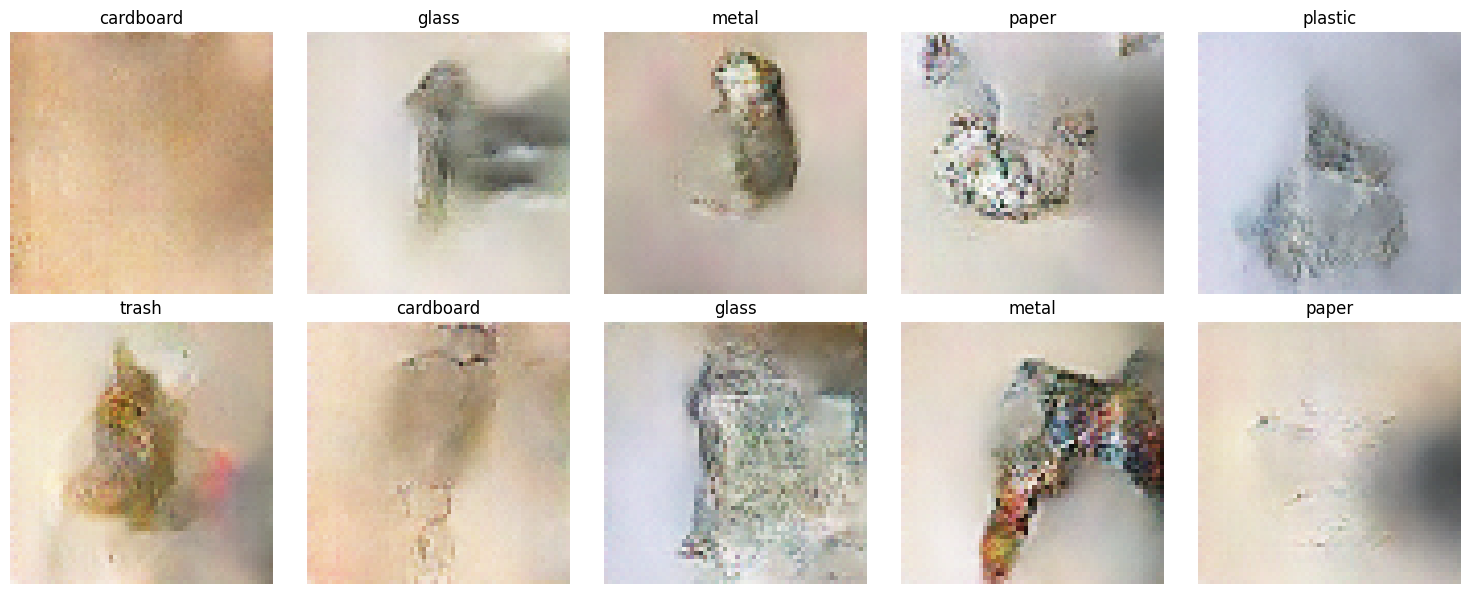

12100 [D loss: 0.3877, acc.: 0.00%] [G loss: 2.1883]
12200 [D loss: 0.3764, acc.: 0.00%] [G loss: 1.8399]
12300 [D loss: 0.3721, acc.: 0.00%] [G loss: 2.0435]
12400 [D loss: 0.3789, acc.: 0.00%] [G loss: 1.8065]
12500 [D loss: 0.4114, acc.: 0.00%] [G loss: 2.1686]
12600 [D loss: 0.5701, acc.: 0.00%] [G loss: 3.3064]
12700 [D loss: 0.3861, acc.: 0.00%] [G loss: 1.9303]
12800 [D loss: 0.3945, acc.: 0.00%] [G loss: 1.9743]
12900 [D loss: 0.3796, acc.: 0.00%] [G loss: 1.9829]
13000 [D loss: 0.3879, acc.: 0.00%] [G loss: 2.0356]


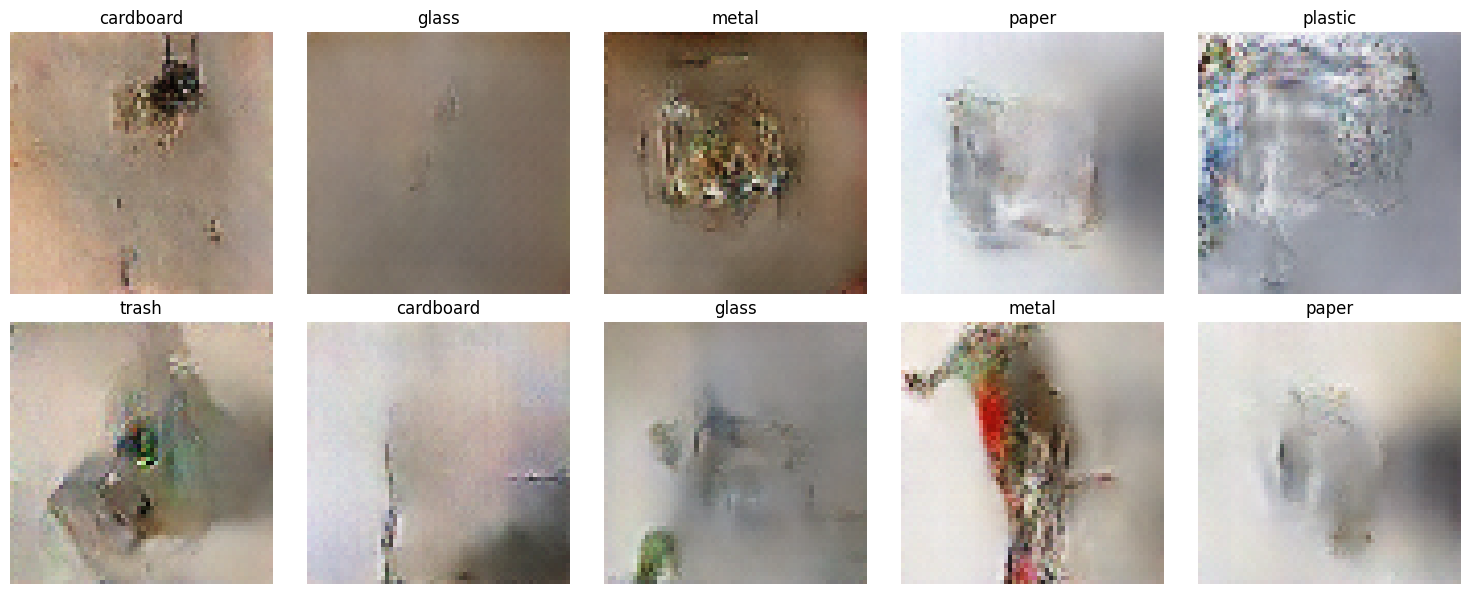

13100 [D loss: 0.3715, acc.: 0.00%] [G loss: 2.0583]
13200 [D loss: 0.4168, acc.: 0.00%] [G loss: 2.3681]
13300 [D loss: 0.3974, acc.: 0.00%] [G loss: 2.0964]
13400 [D loss: 0.4374, acc.: 0.00%] [G loss: 2.0830]
13500 [D loss: 0.4150, acc.: 0.00%] [G loss: 1.9114]
13600 [D loss: 0.3958, acc.: 0.00%] [G loss: 2.2013]
13700 [D loss: 0.3850, acc.: 0.00%] [G loss: 2.0448]
13800 [D loss: 0.3830, acc.: 0.00%] [G loss: 1.9592]
13900 [D loss: 0.3923, acc.: 0.00%] [G loss: 2.0755]
14000 [D loss: 0.3935, acc.: 0.00%] [G loss: 2.0899]


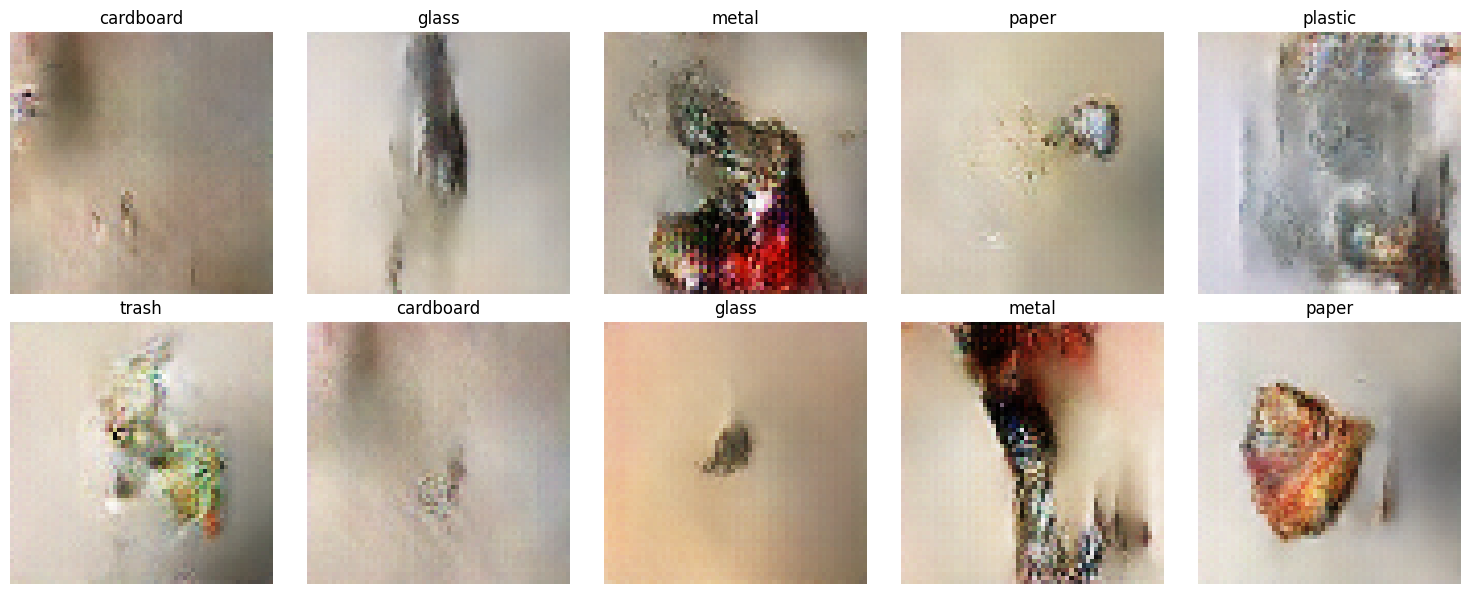

14100 [D loss: 0.4072, acc.: 0.00%] [G loss: 2.4860]
14200 [D loss: 0.3823, acc.: 0.00%] [G loss: 2.0608]
14300 [D loss: 0.3815, acc.: 0.00%] [G loss: 2.0764]
14400 [D loss: 0.4223, acc.: 0.00%] [G loss: 2.2435]
14500 [D loss: 0.3726, acc.: 0.00%] [G loss: 2.0698]
14600 [D loss: 0.3829, acc.: 0.00%] [G loss: 2.0481]
14700 [D loss: 0.3724, acc.: 0.00%] [G loss: 2.0212]
14800 [D loss: 0.4001, acc.: 0.00%] [G loss: 2.0620]
14900 [D loss: 0.3989, acc.: 0.00%] [G loss: 2.2702]
15000 [D loss: 0.4123, acc.: 0.00%] [G loss: 2.1066]


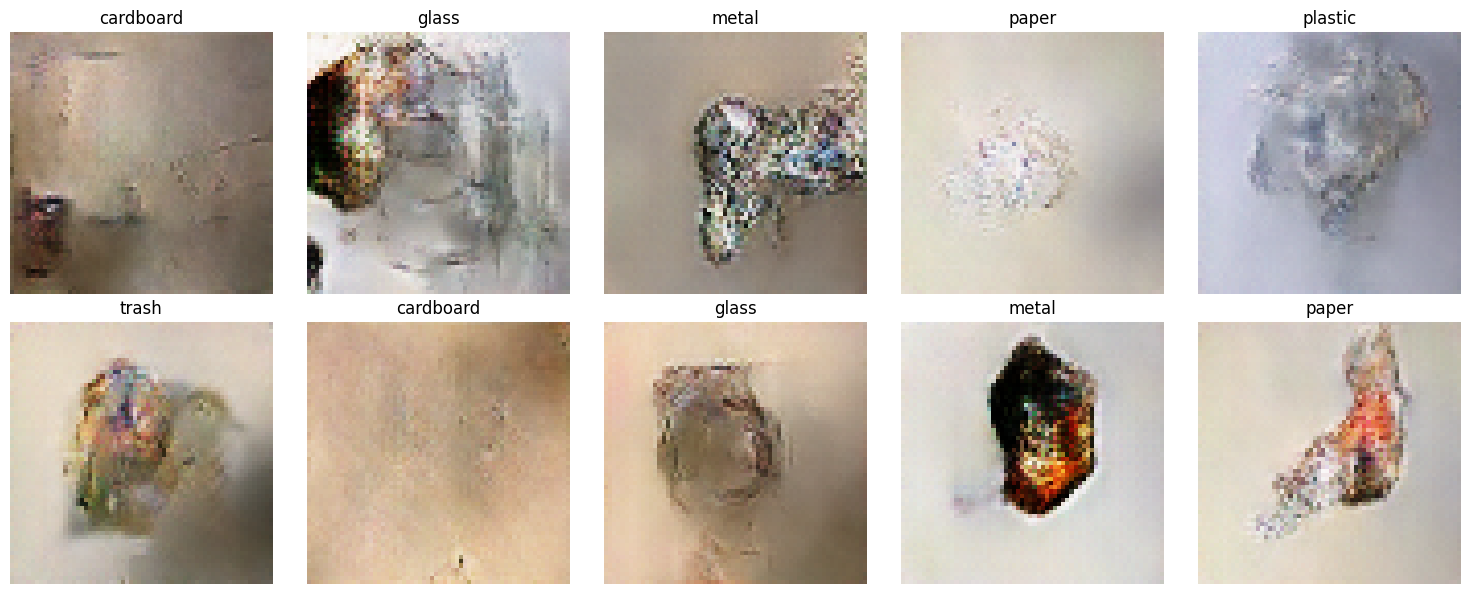

15100 [D loss: 0.3859, acc.: 0.00%] [G loss: 1.8081]
15200 [D loss: 0.3798, acc.: 0.00%] [G loss: 1.7786]
15300 [D loss: 0.3766, acc.: 0.00%] [G loss: 2.0355]
15400 [D loss: 0.3958, acc.: 0.00%] [G loss: 1.7944]
15500 [D loss: 0.3789, acc.: 0.00%] [G loss: 1.9903]
15600 [D loss: 0.3864, acc.: 0.00%] [G loss: 1.9755]
15700 [D loss: 0.3895, acc.: 0.00%] [G loss: 2.0297]
15800 [D loss: 0.3820, acc.: 0.00%] [G loss: 1.7396]
15900 [D loss: 5.3718, acc.: 0.00%] [G loss: 5.3481]
16000 [D loss: 0.3842, acc.: 0.00%] [G loss: 1.7563]


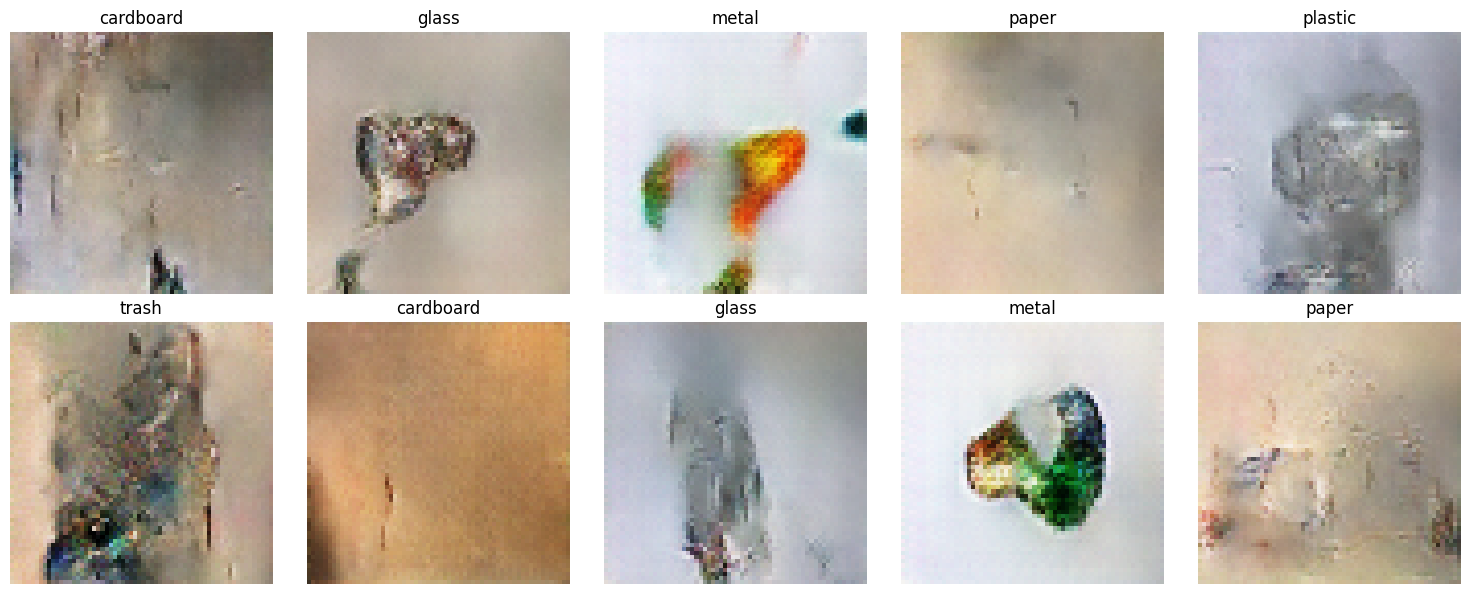

16100 [D loss: 0.3987, acc.: 0.00%] [G loss: 1.9672]
16200 [D loss: 0.4028, acc.: 0.00%] [G loss: 1.9225]
16300 [D loss: 0.3852, acc.: 0.00%] [G loss: 2.0328]
16400 [D loss: 0.3814, acc.: 0.00%] [G loss: 2.1174]
16500 [D loss: 0.4030, acc.: 0.00%] [G loss: 2.2108]
16600 [D loss: 0.3971, acc.: 0.00%] [G loss: 2.0168]
16700 [D loss: 0.3733, acc.: 0.00%] [G loss: 1.9826]
16800 [D loss: 0.3737, acc.: 0.00%] [G loss: 2.1379]
16900 [D loss: 0.4115, acc.: 0.00%] [G loss: 1.8850]
17000 [D loss: 0.3892, acc.: 0.00%] [G loss: 1.9900]


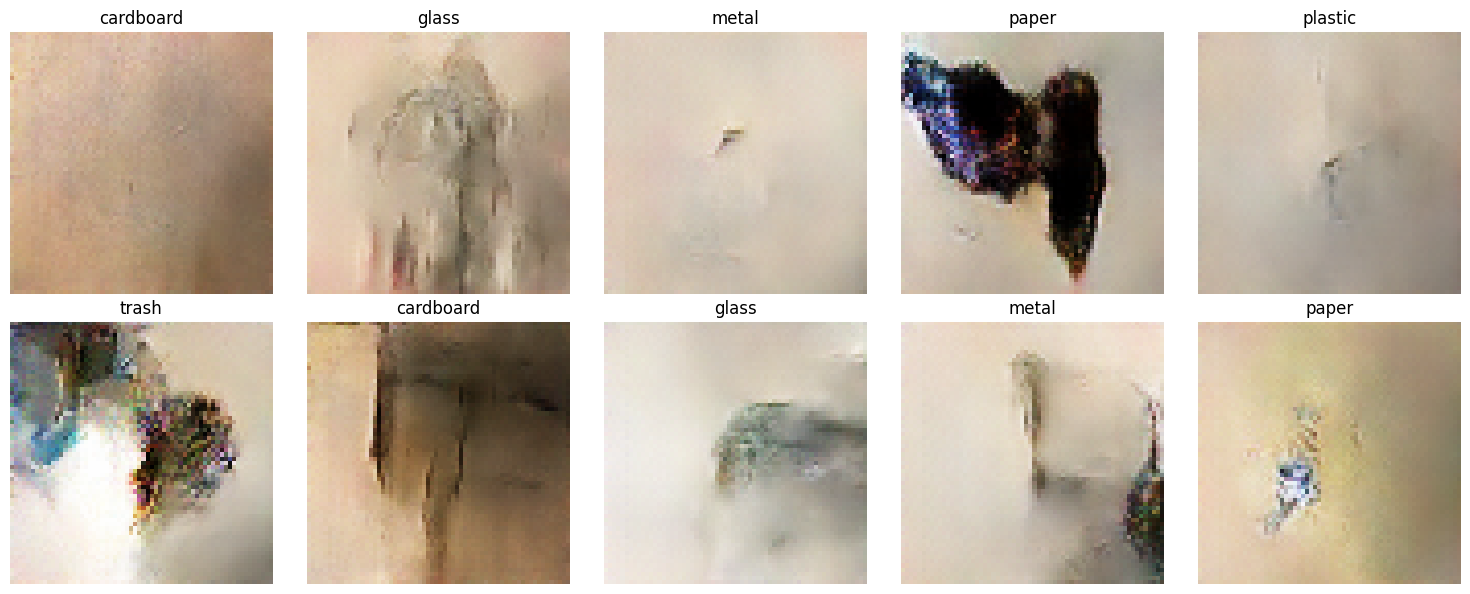

17100 [D loss: 0.4426, acc.: 0.00%] [G loss: 2.7721]
17200 [D loss: 0.4099, acc.: 0.00%] [G loss: 1.9432]
17300 [D loss: 0.3675, acc.: 0.00%] [G loss: 2.1307]
17400 [D loss: 0.3772, acc.: 0.00%] [G loss: 2.0561]
17500 [D loss: 0.3925, acc.: 0.00%] [G loss: 2.4153]
17600 [D loss: 0.3742, acc.: 0.00%] [G loss: 2.0899]
17700 [D loss: 0.3663, acc.: 0.00%] [G loss: 1.9382]
17800 [D loss: 0.3855, acc.: 0.00%] [G loss: 2.0355]
17900 [D loss: 0.3861, acc.: 0.00%] [G loss: 2.2409]
18000 [D loss: 0.3745, acc.: 0.00%] [G loss: 2.0158]


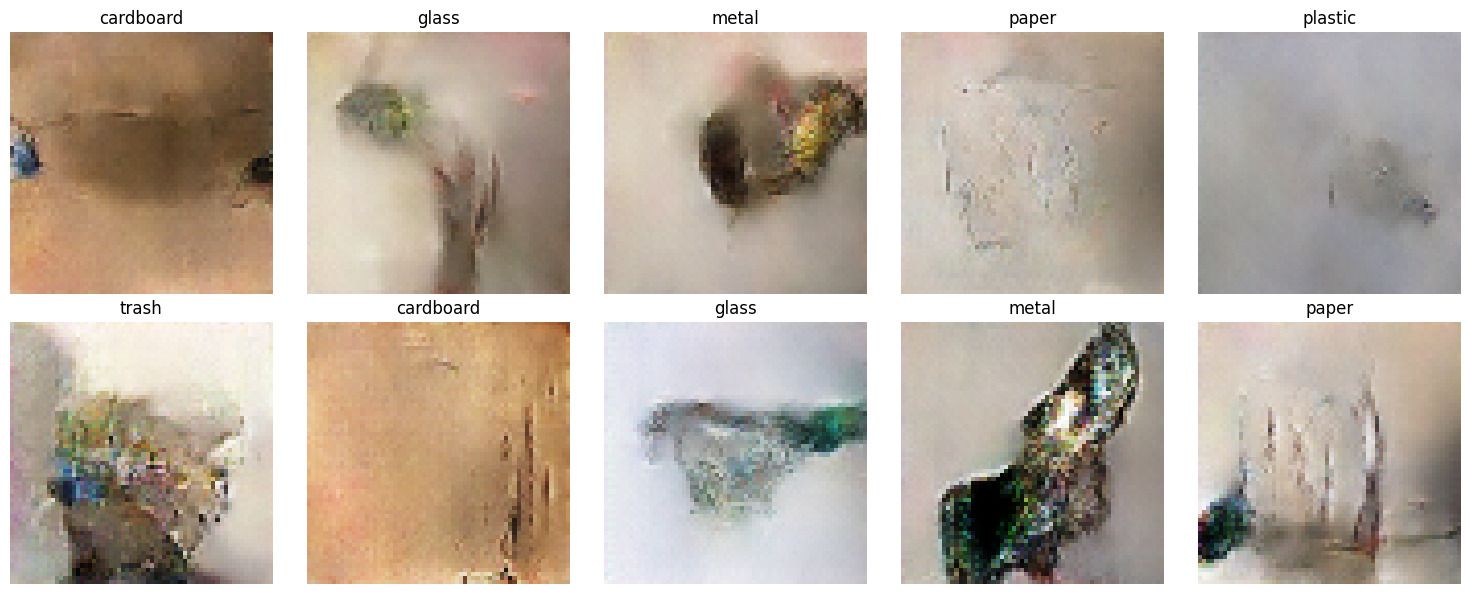

18100 [D loss: 0.3777, acc.: 0.00%] [G loss: 1.9351]
18200 [D loss: 0.4608, acc.: 0.00%] [G loss: 2.0222]
18300 [D loss: 0.4059, acc.: 0.00%] [G loss: 1.9061]
18400 [D loss: 0.4240, acc.: 0.00%] [G loss: 1.9754]
18500 [D loss: 0.3983, acc.: 0.00%] [G loss: 1.9568]
18600 [D loss: 0.3648, acc.: 0.00%] [G loss: 1.7878]
18700 [D loss: 0.3956, acc.: 0.00%] [G loss: 1.9787]
18800 [D loss: 0.4185, acc.: 0.00%] [G loss: 1.9890]
18900 [D loss: 0.4040, acc.: 0.00%] [G loss: 2.1000]
19000 [D loss: 0.3891, acc.: 0.00%] [G loss: 2.1239]


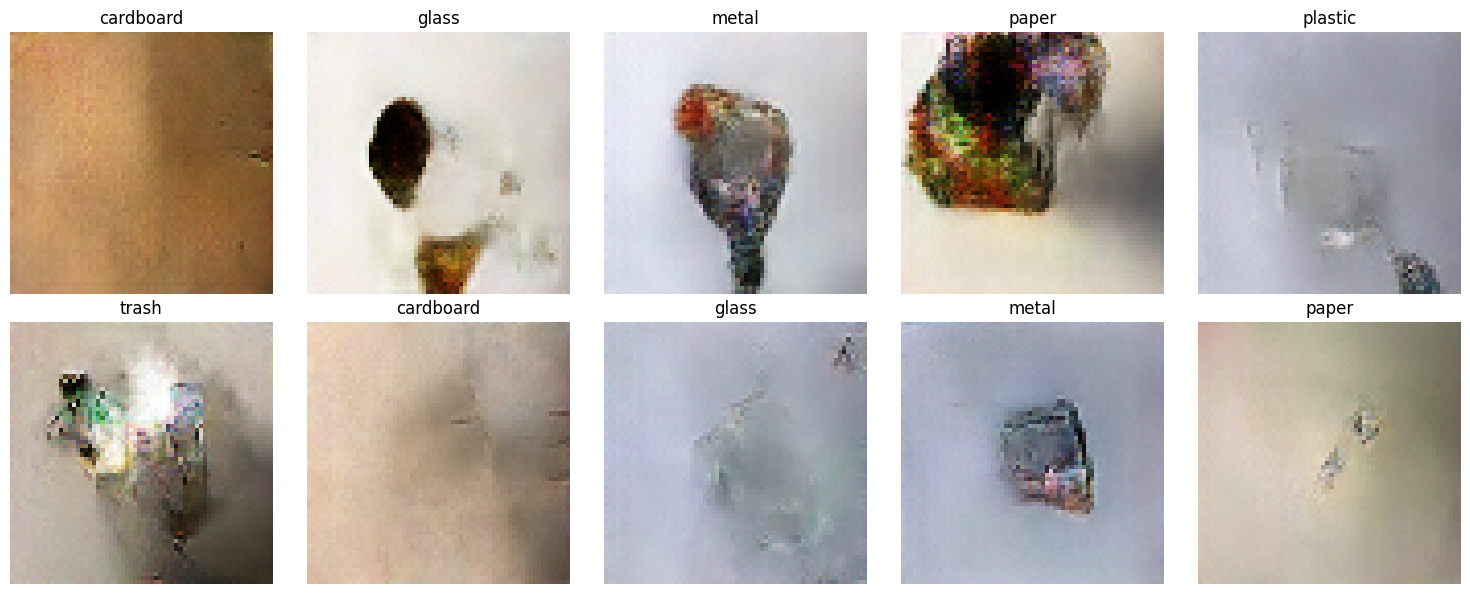

19100 [D loss: 0.3754, acc.: 0.00%] [G loss: 2.2065]
19200 [D loss: 0.3579, acc.: 0.00%] [G loss: 1.9421]
19300 [D loss: 0.3786, acc.: 0.00%] [G loss: 1.7776]
19400 [D loss: 0.3902, acc.: 0.00%] [G loss: 2.0029]
19500 [D loss: 0.3611, acc.: 0.00%] [G loss: 2.0246]
19600 [D loss: 0.3814, acc.: 0.00%] [G loss: 2.1265]
19700 [D loss: 0.3952, acc.: 0.00%] [G loss: 2.0586]
19800 [D loss: 0.3719, acc.: 0.00%] [G loss: 1.9463]
19900 [D loss: 0.3587, acc.: 0.00%] [G loss: 1.9776]
20000 [D loss: 0.4004, acc.: 0.00%] [G loss: 2.0054]


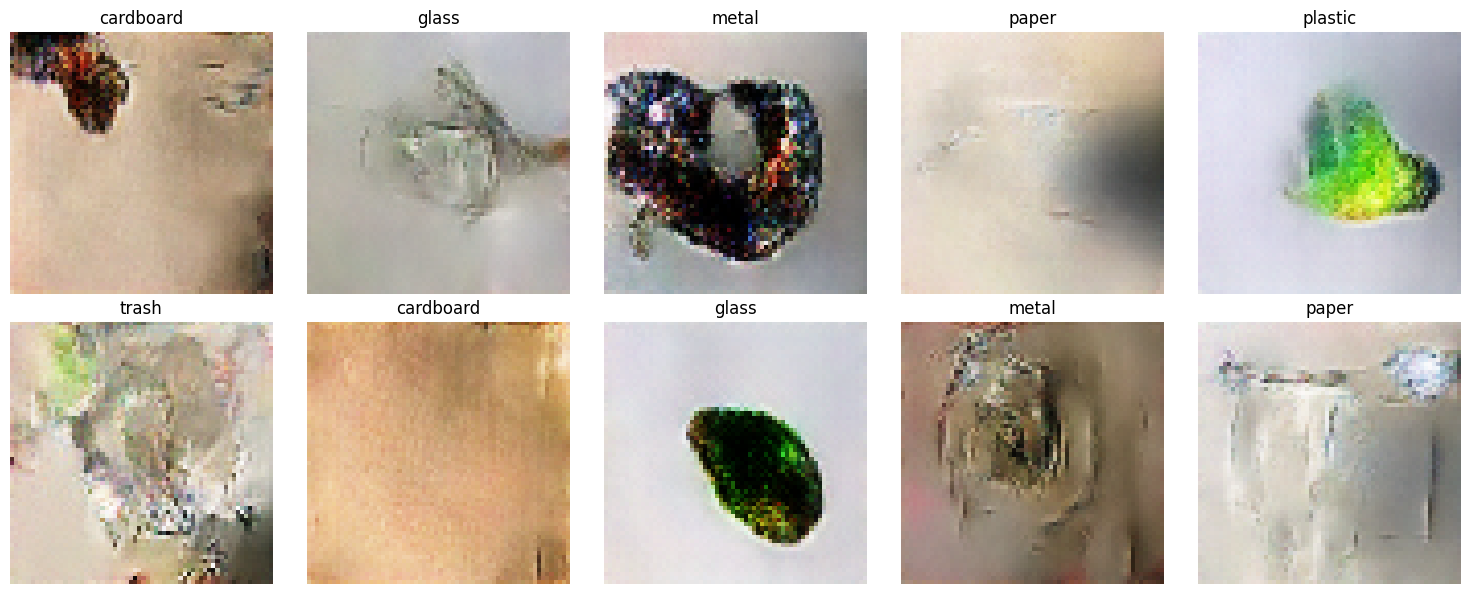

In [ ]:
# Training Loop

epochs = 20000
batch_size = 64
sample_interval = 1000

def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    labels = np.array([i % num_classes for i in range(r * c)]).reshape(-1, 1)
    gen_imgs = generator.predict([noise, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c, figsize=(15, 6))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(f"{classes[labels[cnt][0]]}")
            axs[i, j].axis("off")
            cnt += 1
    plt.tight_layout()
    plt.show()

for epoch in range(epochs + 1):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx].reshape(-1, 1)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    gen_imgs = generator.predict([noise, fake_labels], verbose=0)

    # Label smoothing
    valid = np.ones((batch_size, 1)) * 0.9
    fake = np.zeros((batch_size, 1)) + 0.1

    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, fake_labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    valid = np.ones((batch_size, 1)) * 0.9

    g_loss = combined.train_on_batch([noise, sampled_labels], valid)

    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

    if epoch % sample_interval == 0:
        sample_images(epoch)


In [ ]:
import os

save_dir = r"C:/Users/Begad/Documents/training/final project"
os.makedirs(save_dir, exist_ok=True)  

# Save the models
generator.save(os.path.join(save_dir, "generator_model.h5"))
discriminator.save(os.path.join(save_dir, "discriminator_model.h5"))

print("Models saved successfully at:", save_dir)


Models saved successfully at: C:/Users/Begad/Documents/training/final project
